# Compute Antarctic, depth integrated, cross slope heat transport, online terms

This is the original code created by Adele Morrison. It Cclculates the annual mean heat transport crossing the 1000m isobath. An eddited version of this code was used (check ../python/....) to calculate the monthly transports, and run as a python script on Gadi.

Update Wilma:
This version of the script uses a different 1000 m isobath definition. The isobath definition tested here, is closer to the "real" 1000 m isobath, but can cross it and is sometimes deeper than 1000 m. It is the same used to extract ASC velocity. There might also be some grid cells that are not connected (step-wise) but only diagonally.

Changes that are required for new isobath: (following a [COSIMA-recipe example](https://github.com/COSIMA/cosima-recipes/blob/main/DocumentedExamples/Cross-contour_transport.ipynb))
- New mask: to establish if transport is onshore or offshore

For contour on u-grid: (not done in this version)
- Interpolate transport onto u,v grid

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41827,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:34223,Total threads: 4
Dashboard: /proxy/38575/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:38585,


In [3]:
#session = cc.database.create_session('/g/data/v45/akm157/jupyter_scripts/tides/ryf9091_tides.db')
session = cc.database.create_session()

In [4]:
year = '2095'
exp  = '01deg_jra55v13_ryf9091'
#exp = '01deg_jra55v13_ryf9091_tides_fixed'

start_time = '2095-01-01'
end_time   = '2095-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [6]:
# # reference density value:
# rho_0 = 1035.0
# # specific heat capacity of sea water:
# cp = 3992.1
# lat_range = slice(-90,-59)

# # pick a freezing point temp:
# temp_freezing = -2.5

In [5]:
fig_path = '/g/data/x77/wgh581/Figures/Figures_ASC_and_HeatTransport/'

## Open isobath contour data

In [6]:
isobath_depth = 1000

# Load pre-calculated isobath information
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)

In [6]:
data.files

['contour_depth',
 'h_contour_u',
 'h_contour_t',
 'xt_ocean',
 'yt_ocean',
 'num_points_u',
 'num_points_t',
 'x_index_u',
 'y_index_u',
 'x_index_t',
 'y_index_t',
 'distance_along_contour_u',
 'distance_along_contour_t',
 'lon_along_contour_u',
 'lat_along_contour_u',
 'lon_along_contour_t',
 'lat_along_contour_t']

In [7]:
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

↑ Note that the leftmost point us repeated, required for masking contour above/below done in a later step.

Text(0, 0.5, 'Latitude')

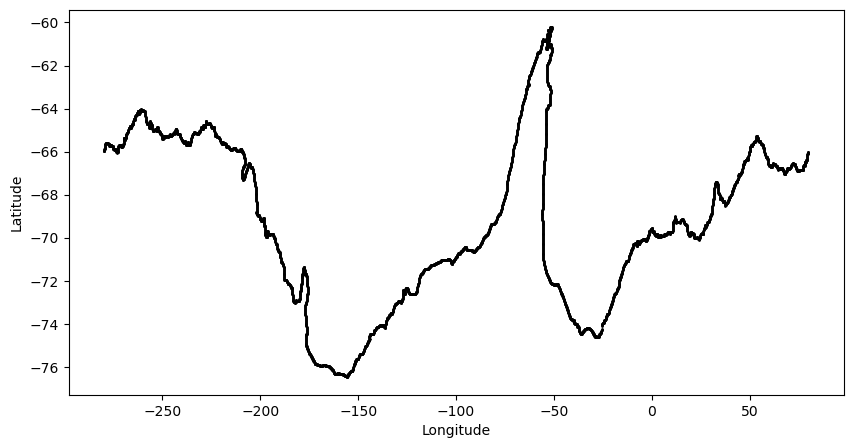

In [8]:
# Plot the contour
plt.figure(figsize=(10,5))
plt.scatter(lon_along_contour, lat_along_contour, color='k', s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### Get latitude band of data

Make sure the contour fits into the range, but there is limited extra space (will slow down computation).

In [8]:
# Get min/max lat values for lat_range from contour
lat_min = np.round(lat_along_contour.min(),0)
lat_max = np.round(lat_along_contour.max(),0)

# Make sure lat_range is outside (poleward and equatorward) of the contour
lat_slice = slice(lat_min-.99, lat_max)

print('lat_min:', lat_min-.99, ', lat_max:', lat_max)

lat_min: -76.99 , lat_max: -60.0


Make sure that this latitude range is so that the t-cells are always south and west of the u-cells. This is important because the meridional and zonal transports occur on different grids to each other. We can check this by loading the u-grid and t-gri coordinates. 

We choose this convetion so that later on when we create `numpy` grids of where the contour is and in what direction the contour goes.

In [26]:
%%time
# Loading data usually takes a little while when performed the first time
yt_ocean = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)

xt_ocean = cc.querying.getvar(exp, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(exp, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)

xu_ocean = cc.querying.getvar(exp, 'xu_ocean', session, n=1)

CPU times: user 5.4 s, sys: 452 ms, total: 5.85 s
Wall time: 19.8 s


In [10]:
# Now check for order of selected lat_slice
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean') > yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean') > xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

## Create contour

Check latitude range

In [6]:
lat_slice = slice(-77.99, -60)

In [7]:
# Loading data usually takes a little while when performed the first time
yt_ocean = cc.querying.getvar(exp, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)

xt_ocean = cc.querying.getvar(exp, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(exp, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)

xu_ocean = cc.querying.getvar(exp, 'xu_ocean', session, n=1)

# Decide which grid to calculate the contour on (the code currently only works for t-grid though)
x_var = xt_ocean
y_var = yt_ocean
# x_var = xu_ocean
# y_var = yu_ocean

In [8]:
# Now check for order of selected lat_slice
if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean') > yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean') > xu_ocean.min('xu_ocean'):
    print('help! x wrong order')

Load bathymetry

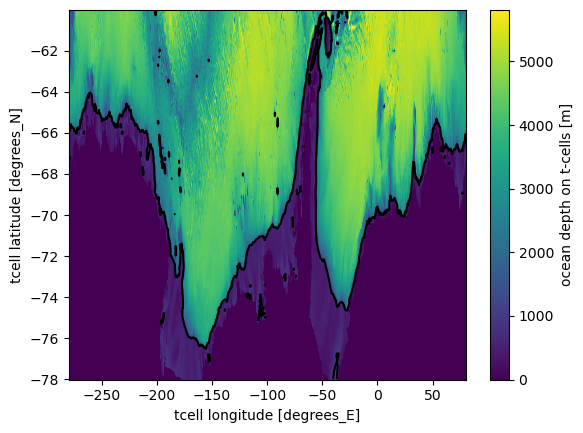

In [9]:
h = cc.querying.getvar(exp, 'ht', session, n=1)
h = h.sel(yt_ocean=lat_slice).load()

# Define depth level to calculate contour for
contour_depth = 1000
# Fill land with zeros
h = h.fillna(0)

h.plot()
h.plot.contour(levels=[contour_depth], colors='k')

#### Select the contour

If there are multiple contours satisfying this contour level, change the count in the if statement below until desired contour is highlighted red. Counting starts from the south west. Play aorund with `count = x` to find the desired contour.
Processing

Now process these coordinates to make sure there are no double ups.


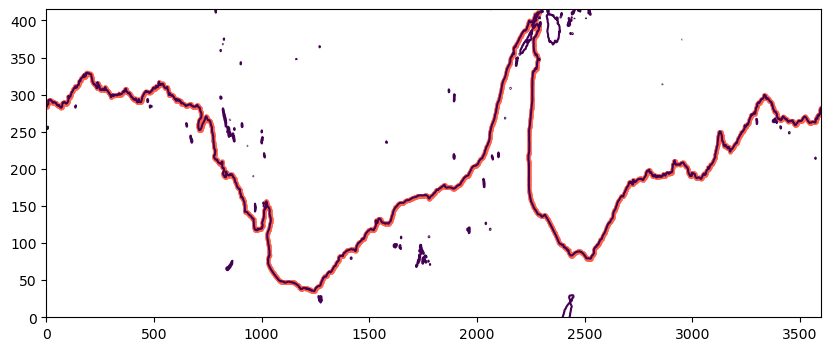

In [10]:
fig = plt.figure(figsize = (10, 4))
count = 0
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        count += 1
        if count == 2:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');



##### Processing

Now process these coordinates to make sure there are no double ups.


In [11]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [12]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]


In [13]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]


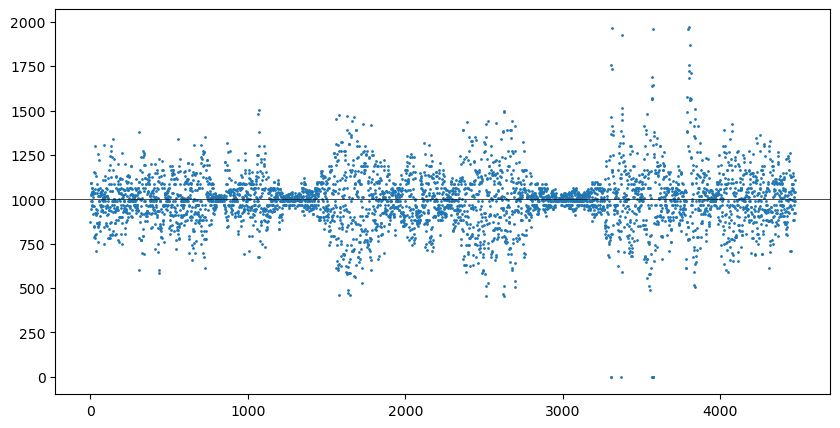

In [14]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);


##### Get lat and lon along the contour

In [15]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[x_contour[ii]]
    lat_along_contour[ii] = y_var[y_contour[ii]]


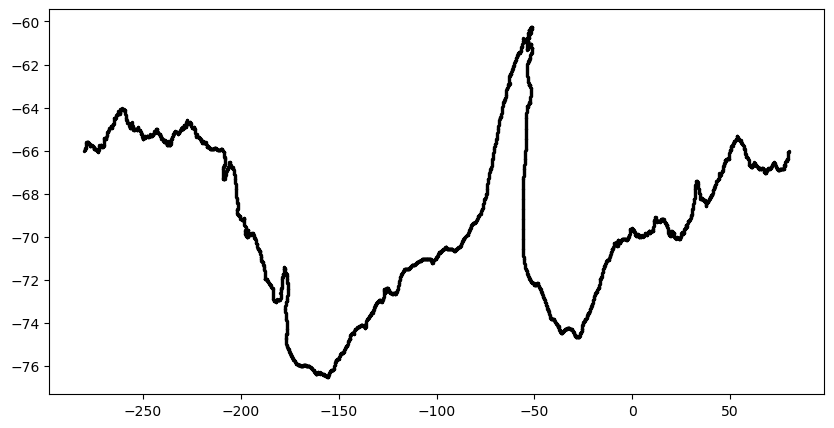

In [16]:
plt.figure(figsize=(10,5))

plt.scatter(lon_along_contour, lat_along_contour, color='k', s=2)

##### Repeat the leftmost point at the end of the array

(Required for masking contour above and below)

In [17]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [18]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

## Number points along the contour

In [19]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    # lat1 = lat_along_contour[ii]
    # lat2 = lat_along_contour[ii+1]
    # lon1 = lon_along_contour[ii]
    # lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

Prepare creating a contour mask, first load any data on desired grid

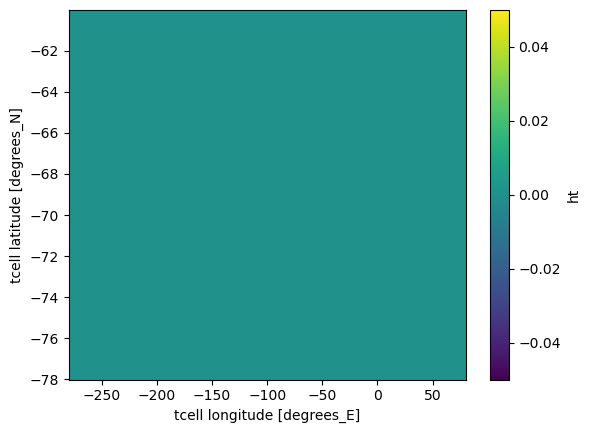

In [20]:
# Use data on the grid you want

# t-grid in this case, so use the already loaded bathymetry ht
contour_mask = h*0
contour_mask.plot()



# # Load some data on the u-grid in this case
# u = cc.querying.getvar(exp,'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
# u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).sel(st_ocean=0, method='nearest')

# # We only need x,y field (select first time step only)
# u = u[0,...] 
# # Fill in land with zeros
# u = u.fillna(0)

# contour_mask = u*0
# contour_mask.plot()

Count contour points on grid

In [205]:
# The code below should work, but for some reason there is an issue with the lon component.
# MAybe xarray does some weird averaging so it doesn't find the same values?

# test = contour_mask.where((contour_mask.yu_ocean!=lat_along_contour[10]) & (contour_mask.xu_ocean!=lon_along_contour[10]), 1)

# test = contour_mask.where(contour_mask.xu_ocean.values!=lon_along_contour[10], 1) # doesn't work
# test = contour_mask.where(contour_mask.yu_ocean!=lat_along_contour[10], 1) # works


In [21]:
# contour_mask = u*0

for ii in range(len(lat_along_contour)):  # nump_points-1
    x_index = np.where(contour_mask.xt_ocean.values == lon_along_contour[ii])[0][0]
    y_index = np.where(contour_mask.yt_ocean.values == lat_along_contour[ii])[0][0]
    contour_mask[y_index, x_index] = contour_mask_numbered[ii] + 1

contour_mask = contour_mask.load()

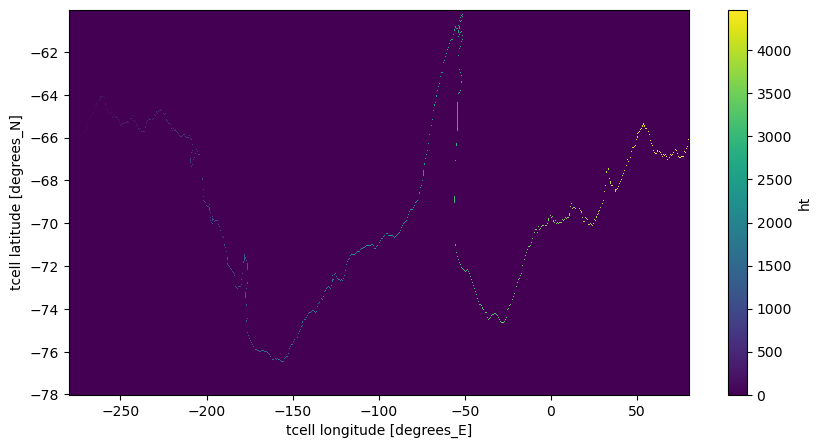

In [22]:
plt.figure(figsize=(10,5))
contour_mask.plot()

↑ Note: it looks like there is a data gap, e.g., eastern Antarctic Peninsula. This is just a plotting feature, when zooming in, there is data:

(-75.0, -50.0)

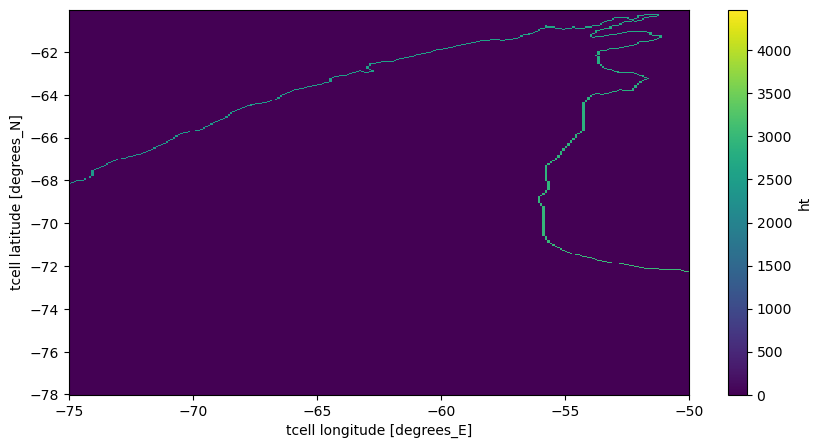

In [23]:
plt.figure(figsize=(10,5))
contour_mask.plot()
plt.xlim(-75, -50)

#### Create mask

Now we create a mask that can distinguish between poleward and equatorward of the contour so that the direction of the contour can be determined.

Make sure the contour is closed, diagonal connections are fine, but the below code won't work for gaps. 

In [24]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 22.1 s, sys: 267 ms, total: 22.3 s
Wall time: 22.1 s


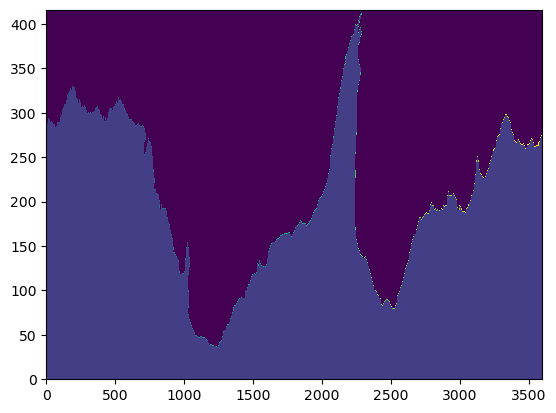

In [25]:
plt.pcolormesh(contour_masked_above)

(200.0, 320.0)

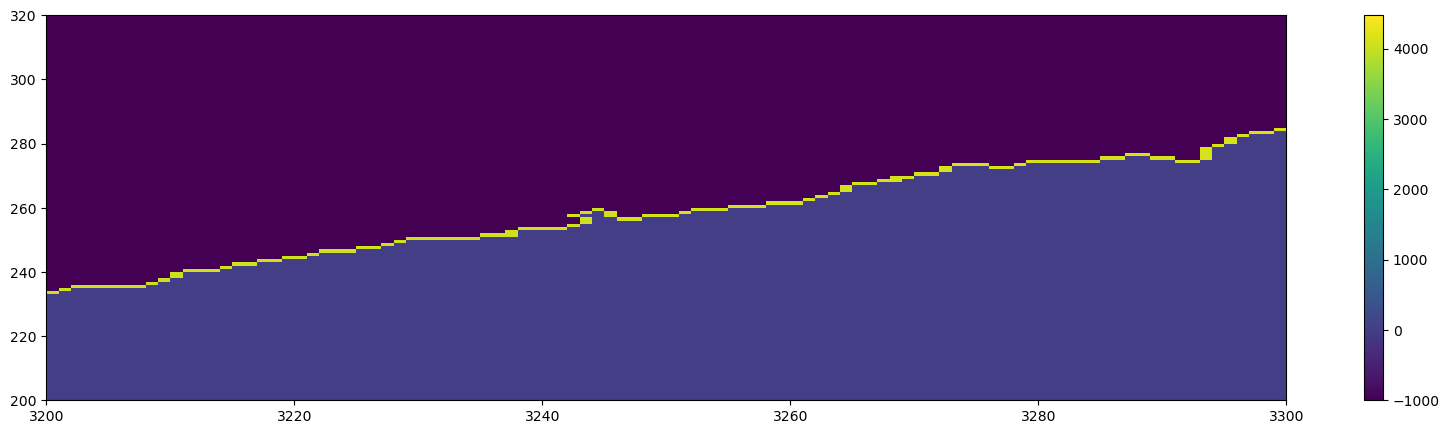

In [39]:
plt.figure(figsize=(20,5))
plt.pcolormesh(contour_masked_above)#,vmin=-1000,vmax=-100)
plt.colorbar()
plt.xlim(3200,3300)
plt.ylim(200,320)

#### Direction of cross-contour transport

Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour) and -100 (below contour). This means the orientation of the contour can be determined. This is saved as `mask_x_transport`, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and `mask_y_transport` which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport `ty_trans` by the `mask_y_transport` gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).

In [40]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
        
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

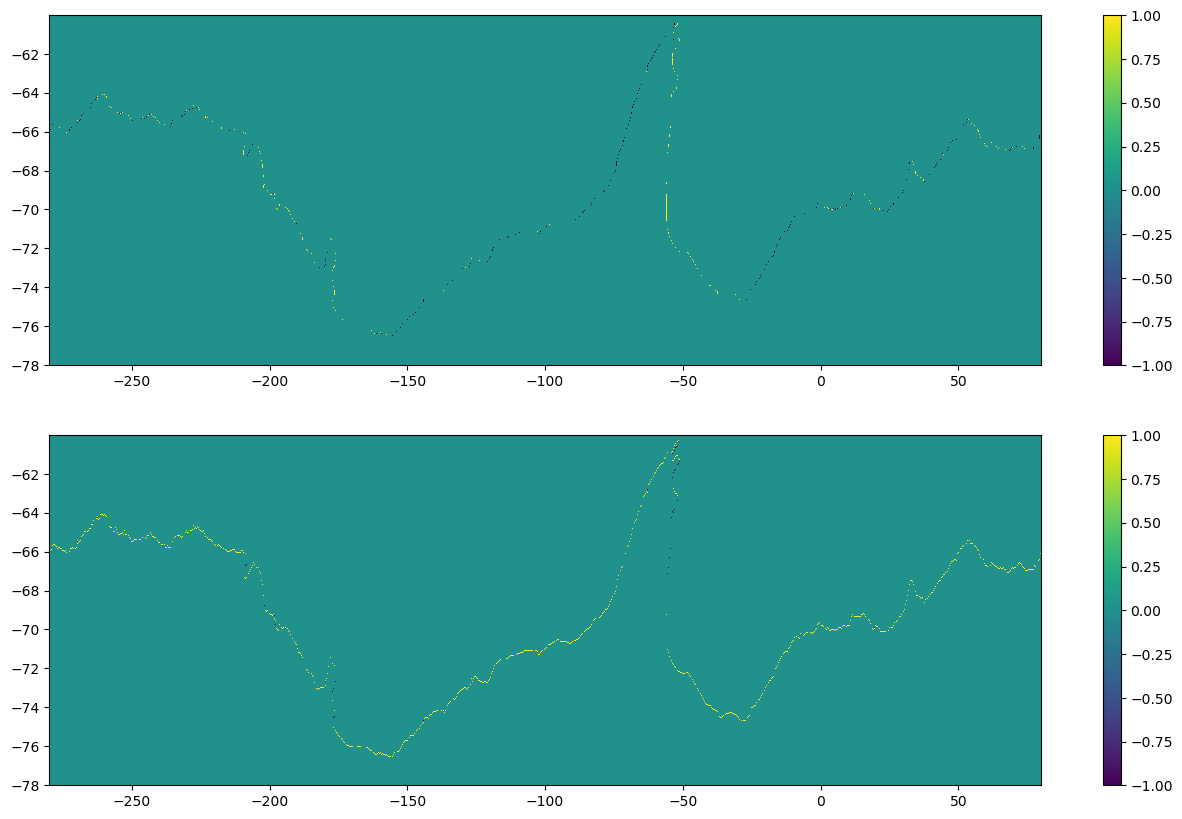

In [41]:
plt.figure(1, figsize=(16, 10))

plt.subplot(211)
plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport)
plt.colorbar()

plt.subplot(212)
plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_y_transport)
plt.colorbar();

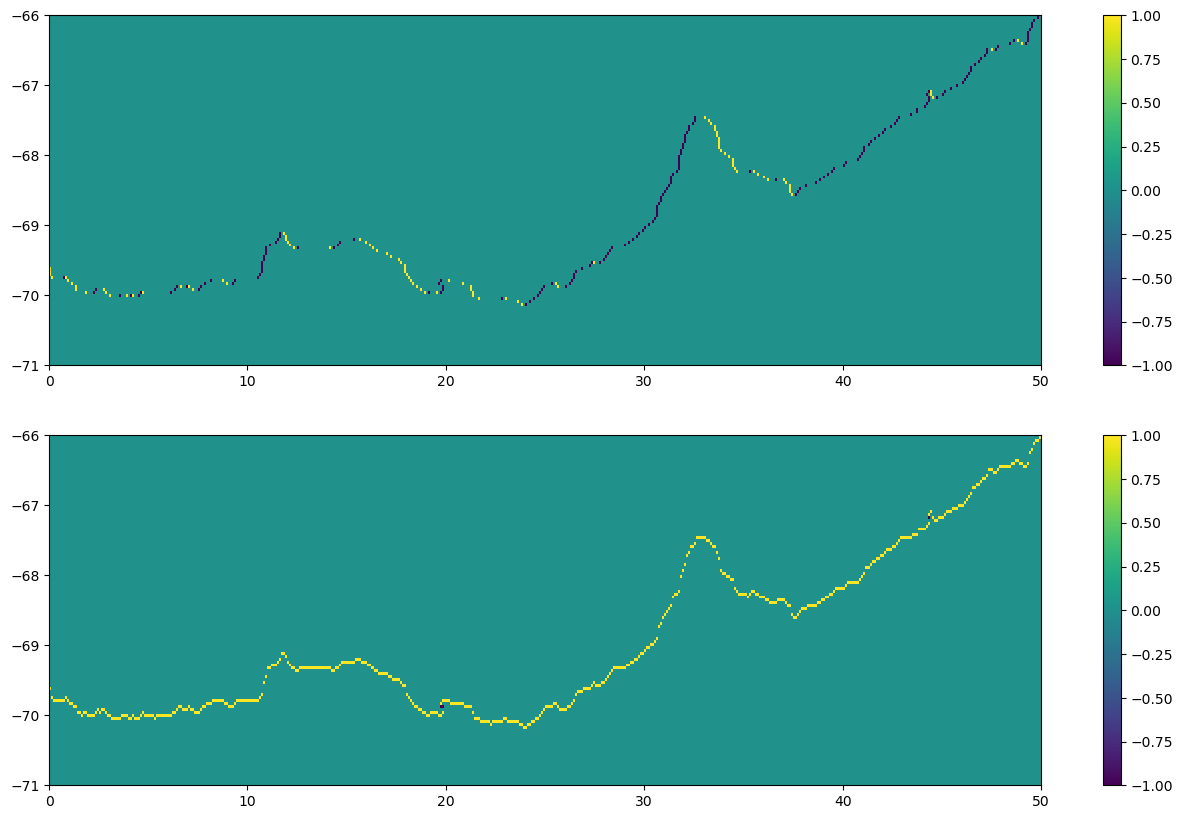

In [28]:
# Zoom in to see details
plt.figure(1, figsize=(16, 10))

plt.subplot(211)
plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport)
plt.colorbar()
plt.xlim(0,50)
plt.ylim(-71,-66)

plt.subplot(212)
plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_y_transport)
plt.colorbar()
plt.xlim(0,50)
plt.ylim(-71,-66);

Write as DataArray

In [42]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords=[yt_ocean, xu_ocean], dims=['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords=[yu_ocean, xt_ocean], dims=['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords=[yt_ocean, xu_ocean], dims=['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords=[yu_ocean, xt_ocean], dims=['y_ocean','x_ocean'])


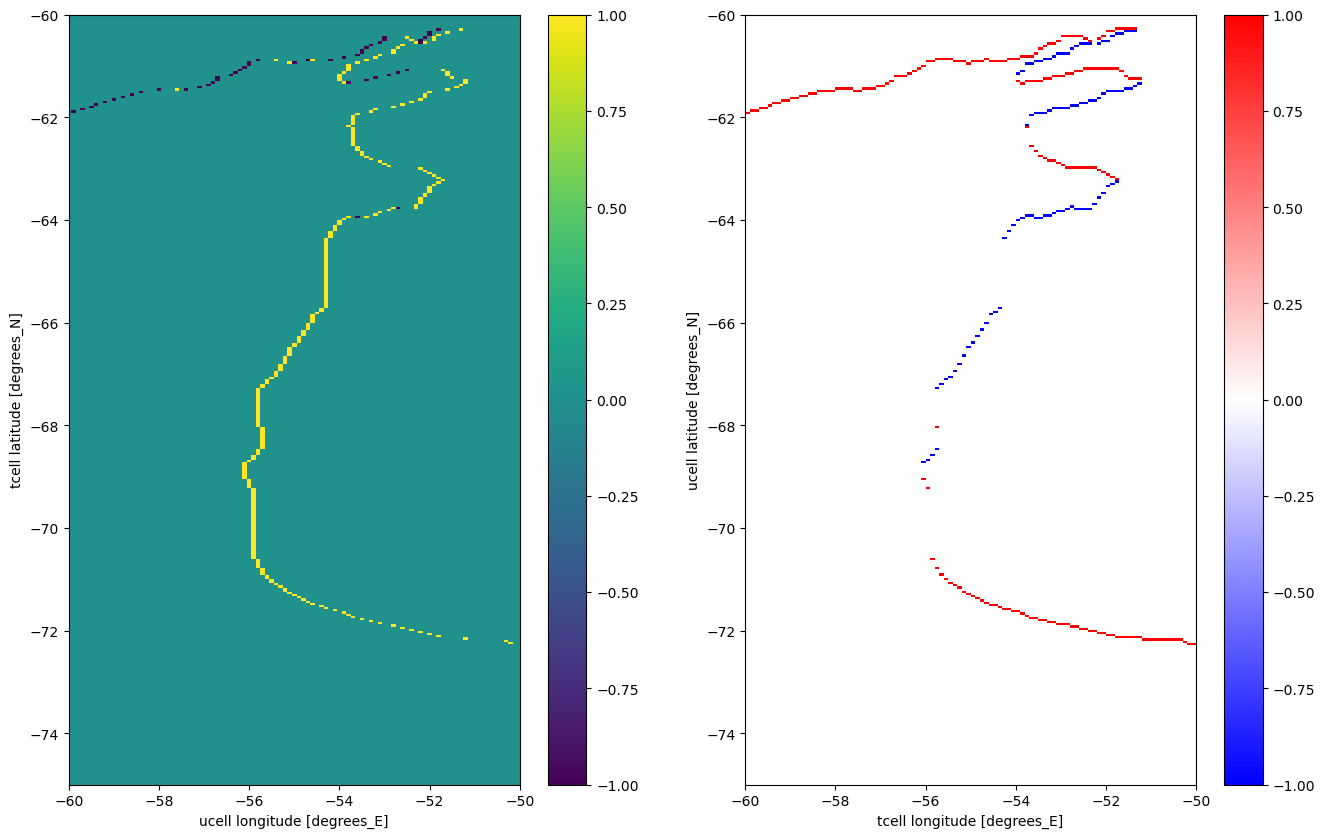

In [48]:
# Plot to confirm we did not mess up anything

xmin = -60
xmax = -50
ymin = -75
ymax = -60

plt.figure(1, figsize=(16, 10))

plt.subplot(121)
mask_x_transport.plot(cmap="viridis");
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)

plt.subplot(122)
mask_y_transport.plot(cmap="bwr")
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax);

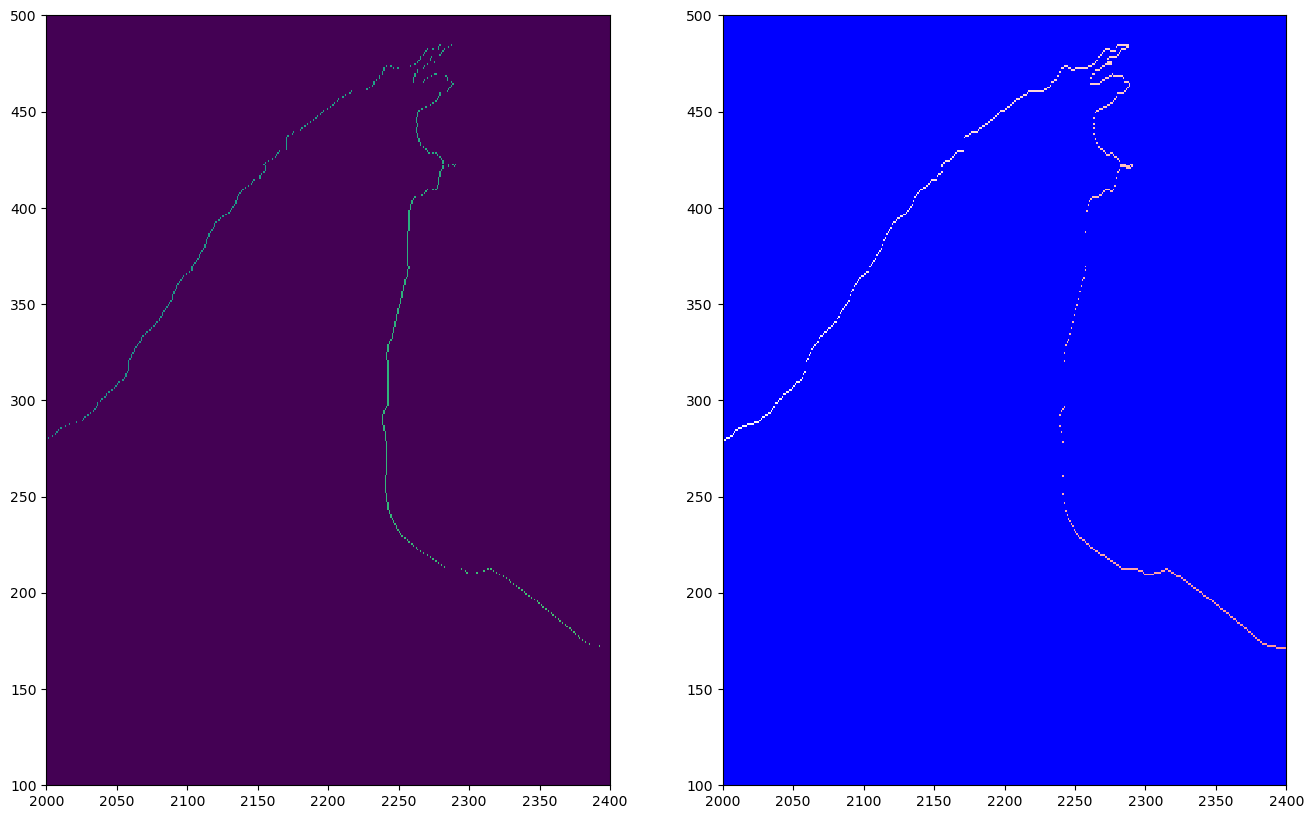

In [62]:
# Testing Adele's mask
xmin = 2000
xmax = 2400
ymin = 100
ymax = 500

plt.figure(1, figsize=(16, 10))

plt.subplot(121)
plt.pcolormesh(x_indices_masked_a, cmap="viridis");
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)

plt.subplot(122)
plt.pcolormesh(y_indices_masked_a, cmap="bwr");
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax);

Stack contour data into 1D

In [63]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)


##### Finally, extract the coordinated of the contour index and distance along contour for a more meaningfull x-axis

In [64]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

... a few more steps but they take a bit, continue with heat transport calculation first to see if it is reasonable.

#### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

We can now proceed to prepare the heat transport and then select the transport across the contour.

### Compute heat transport

##### Total heat transport is calculated by the model online

In [65]:
# Note temp_yflux_adv is, similar to ty_trans, positioned on north centre edge of t-cell.
# temp_yflux_adv = cp*rho*dzt*dxt*v*temp

temp_yflux = cc.querying.getvar(exp, 'temp_yflux_adv', session,start_time=start_time, end_time=end_time)
temp_xflux = cc.querying.getvar(exp, 'temp_xflux_adv', session,start_time=start_time, end_time=end_time)

# select latitude range:
temp_yflux = temp_yflux.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time))
temp_xflux = temp_xflux.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

# time average and sum in depth:
temp_yflux = temp_yflux.mean('time').sum('st_ocean')
temp_xflux = temp_xflux.mean('time').sum('st_ocean')

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

##### Calculate freezing point heat transport

We need to subtract the transport at freezing point (fp). To do so, we need to calculate the fp heat transport separately.

In [66]:
# Online 
vhrho_nt = cc.querying.getvar(exp, 'vhrho_nt', session, start_time=start_time, end_time=end_time)
uhrho_et = cc.querying.getvar(exp, 'uhrho_et', session, start_time=start_time, end_time=end_time)

vhrho_nt = vhrho_nt.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
uhrho_et = uhrho_et.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))

vhrho_nt = vhrho_nt.mean('time')
uhrho_et = uhrho_et.mean('time')

# More accurate time average:
# days_in_month = ssh.time.dt.days_in_month
# days_in_year = 365
# data = (data * days_in_month / days_in_year).sum('time')

In [67]:
# Grid info
xt_ocean_full = cc.querying.getvar(exp, 'xt_ocean', session, n=1)
yt_ocean_full = cc.querying.getvar(exp, 'yt_ocean', session, n=1)

dxu_full = cc.querying.getvar(exp, 'dxu', session, n=1)
dyt_full = cc.querying.getvar(exp, 'dyt', session, n=1)

# give dxu and dyt correct coordinates:
dxu_full.coords['nj'] = yt_ocean_full.values
dxu_full.coords['ni'] = xt_ocean_full['xt_ocean'].values
dxu_full = dxu_full.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

dyt_full.coords['nj'] = yt_ocean_full.values
dyt_full.coords['ni'] = xt_ocean_full['xt_ocean'].values
dyt_full = dyt_full.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

# select latitude range:
dxu = dxu_full.sel(yt_ocean=lat_slice)
dyt = dyt_full.sel(yt_ocean=lat_slice)

Convert from mass to volume transport

In [68]:
# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
# but there is a problem with this diagnostic in older runs, and even
# using ty_trans, there is a slight difference. Not sure why?

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
# sum in depth:
vhrho_nt = vhrho_nt.sum('st_ocean')
uhrho_et = uhrho_et.sum('st_ocean')

# Reference density value (from model)
rho_0 = 1035.0

# convert to transport:
vhrho_nt = vhrho_nt*dxu/rho_0
uhrho_et = uhrho_et*dyt/rho_0

# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
yu_ocean = cc.querying.getvar(exp, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)
vhrho_nt.coords['yt_ocean'] = yu_ocean.values
vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
uhrho_et.coords['xt_ocean'] = xu_ocean.values
uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))

Calculate freezing point transport and subtract from total transport

In [69]:
# Specific heat capacity of sea water
cp = 3992.1
# Pick a freezing point temperature
temp_freezing = -3.82

# Calculate freezing point heat transport
freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing

In [70]:
%%time
# Subtract from total heat transport
temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
temp_xflux = temp_xflux - freezing_point_heat_trans_zonal

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

CPU times: user 10min 1s, sys: 49.1 s, total: 10min 50s
Wall time: 17min 11s


In [71]:
temp_yflux = temp_yflux.rename({'yu_ocean': 'y_ocean', 'xt_ocean': 'x_ocean'})
temp_xflux = temp_xflux.rename({'yt_ocean': 'y_ocean', 'xu_ocean': 'x_ocean'})

#### Extract values along contour

In [90]:
# # multiply by isobath contour masks:
# temp_yflux_with_mask = temp_yflux*mask_y_transport
# temp_xflux_with_mask = temp_xflux*mask_x_transport

temp_xflux = temp_xflux * mask_x_transport
temp_yflux = temp_yflux * mask_y_transport


In [91]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = temp_xflux.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = temp_yflux.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
heat_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
heat_trans_across_contour = heat_trans_across_contour.sortby(contour_ordering)
heat_trans_across_contour.coords['contour_index'] = contour_index_array
heat_trans_across_contour = heat_trans_across_contour.load()


CPU times: user 399 ms, sys: 28.1 ms, total: 427 ms
Wall time: 380 ms


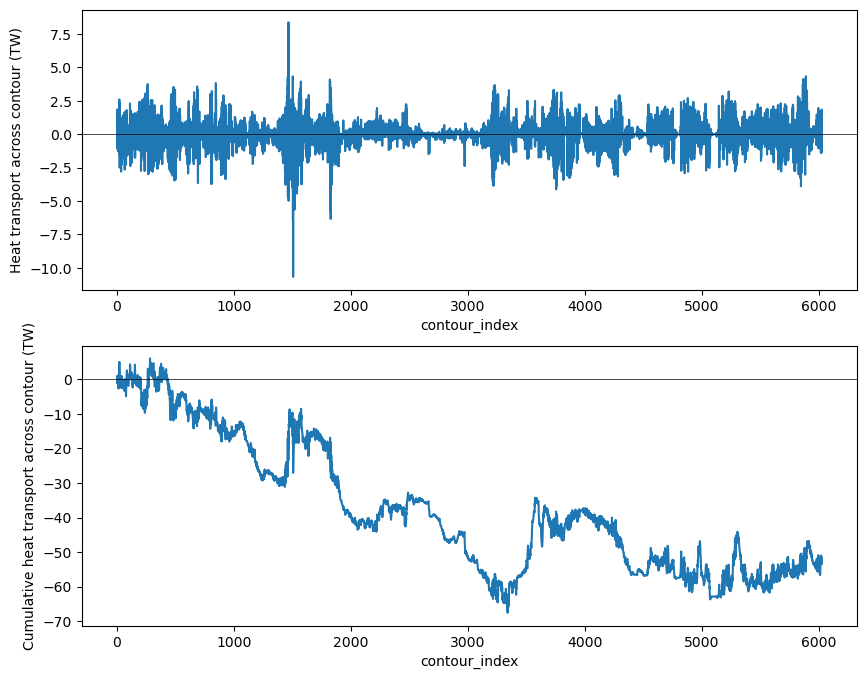

In [92]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.subplot(211)
(heat_trans_across_contour*1e-12).plot()
plt.ylabel('Heat transport across contour (TW)')
plt.axhline(0, color='k', linewidth=0.5);

plt.subplot(212)
(heat_trans_across_contour.cumsum('contour_index')*1e-12).plot()
plt.ylabel('Cumulative heat transport across contour (TW)')
plt.axhline(0, color='k', linewidth=0.5);

save_fig = 0
if save_fig == 1:
    plt.savefig(fig_path + 'HT_1km_t_grid_orig_contour.png')

In [99]:
print(heat_trans_across_contour.mean().values)
print(heat_trans_across_contour.std().values)
print(heat_trans_across_contour.sum().values*1e-12)
print(len(heat_trans_across_contour))

-8789833000.0
1053737222144.0
-52.958741921792
6025


#### Zonal convergence

A lot of the transport enters and leaves the contour, calculate zonal convergence to get rid of the problem.

In [101]:
# convert to longitude coordinate and average into 3 degree longitude bins:

# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west, lon_east+bin_spacing, bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2, lon_east-bin_width/2, bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    if np.size(same_lon_points==1):
        bin_edge_indices[lon_bin] = same_lon_points[0]
    else:
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# sum heat transport from isobath coord into new longitude coord:
cross_slope_heat_trans = np.zeros(n_bins)
for lon_bin in range(n_bins):
    heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    cross_slope_heat_trans[lon_bin] = np.sum(heat_trans_this_bin)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

Factor to account for overlapping bins

Bins are moved every 0.25$^{\circ}$ with a 3$^{\circ}$ width. Calculate the factor to normalise the transport

In [102]:
factor = (np.sum(heat_trans_across_contour) / np.sum(cross_slope_heat_trans)).values

Now calculate zonal convergence

In [103]:
%%time

# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
# longitude averaging above, by using same bin_edge_indices.
# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
# if on y grid, sum zonal transport on nearest u grid point to west.

zonal_heat_trans_west = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # west limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
        if ii==0:
            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
        else:
            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

zonal_heat_trans_east = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # east limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # wrap around to east side of grid:
        if ii==0:
            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
        else:
            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

CPU times: user 54.2 s, sys: 797 ms, total: 55 s
Wall time: 49.8 s


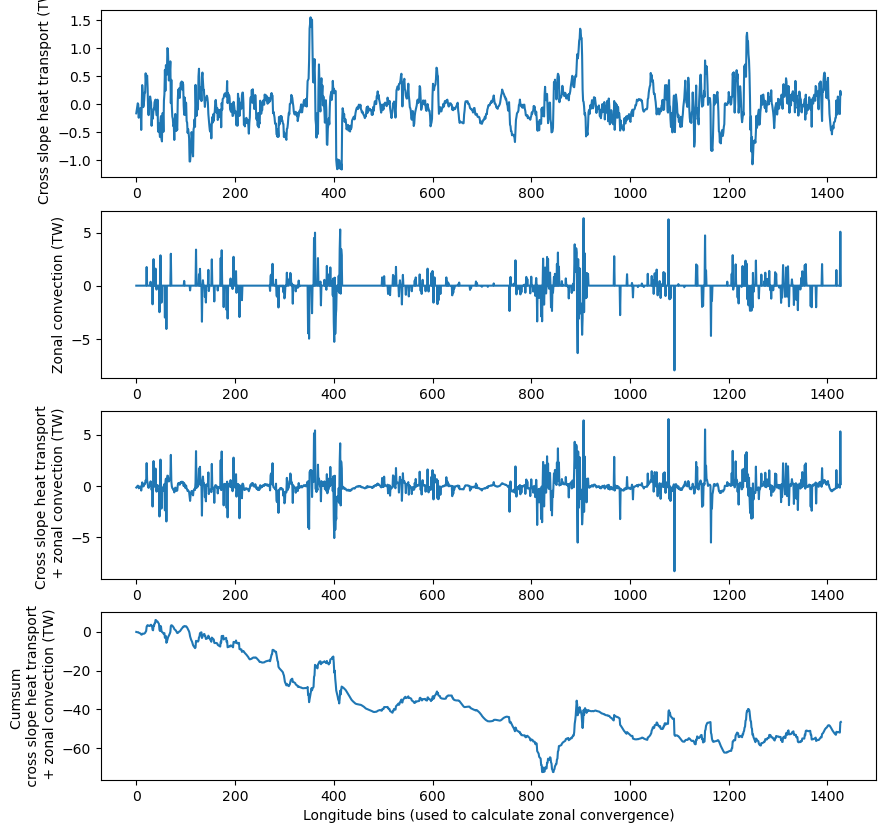

In [105]:
fig = plt.figure(figsize=(10,10))

plt.subplot(411)
plt.plot(factor*cross_slope_heat_trans*1e-12)
plt.ylabel('Cross slope heat transport (TW)')

plt.subplot(412)
plt.plot(zonal_convergence*1e-12)
plt.ylabel('Zonal convection (TW)')

plt.subplot(413)
plt.plot(((factor*cross_slope_heat_trans)+zonal_convergence)*1e-12)
plt.ylabel('Cross slope heat transport \n + zonal convection (TW)')

plt.subplot(414)
plt.plot(np.cumsum(((factor*cross_slope_heat_trans)+zonal_convergence))*1e-12)
plt.ylabel('Cumsum \n cross slope heat transport \n + zonal convection (TW)')
plt.xlabel('Longitude bins (used to calculate zonal convergence)')

save_fig = 1
if save_fig == 1:
    plt.savefig(fig_path + 'HT_1km_t_grid_lon_bins.png')

In [106]:
((cross_slope_heat_trans.sum() * factor ) + zonal_convergence.sum() ) * 1e-12

-46.407940046848

---

### Compare location of 1km-contours

In [51]:
# Adele's 1 km contour

contour_data_a  = np.load('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz')
contour_mask_numbered_a = contour_data_a['contour_mask_numbered']
contour_1000m_a = np.where(contour_mask_numbered_a==0, contour_mask_numbered_a, 1000)
contour_xt_ocean_a = contour_data_a['xt_ocean']
contour_yt_ocean_a = contour_data_a['yt_ocean']

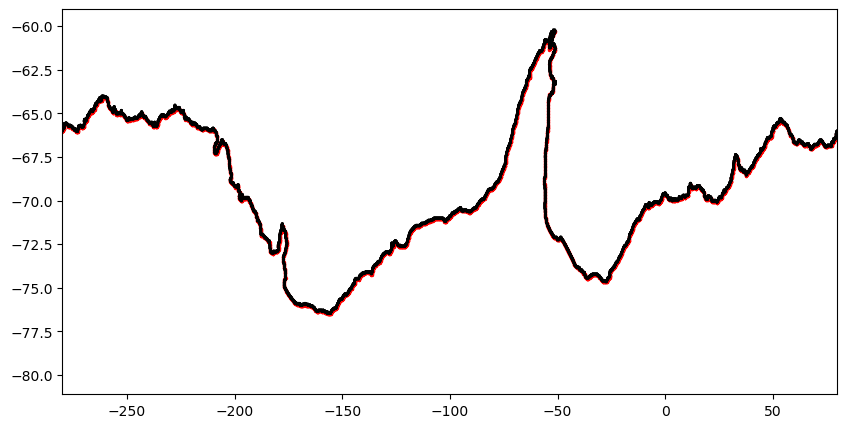

In [84]:
plt.figure(figsize=(10,5))

plt.contour(contour_xt_ocean_a, contour_yt_ocean_a, contour_1000m_a, colors='k')

plt.scatter(lon_along_contour, lat_along_contour, color='r', s=2)

(-74.0, -70.0)

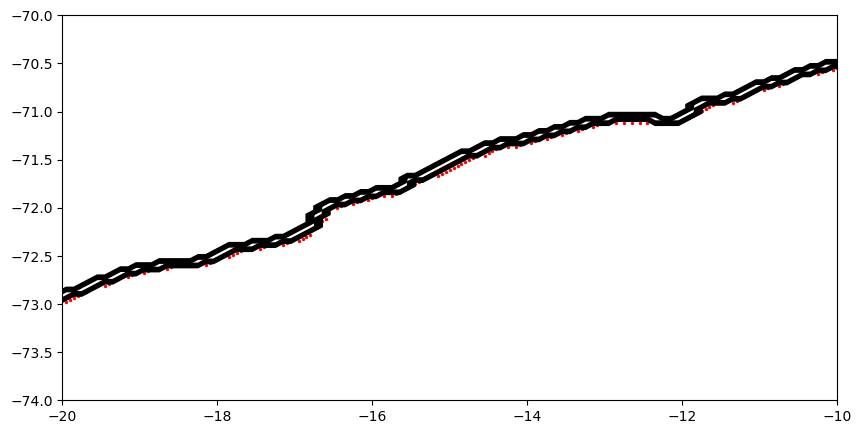

In [86]:
plt.figure(figsize=(10,5))

plt.contour(contour_xt_ocean_a, contour_yt_ocean_a, contour_1000m_a, colors='k')

plt.scatter(lon_along_contour, lat_along_contour, color='r', s=2)

plt.xlim(-20, -10)
plt.ylim(-74, -70)

In [52]:
isobath_depth = 1000
lat_range = slice(-90,-59)
outfile_a = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data_a = np.load(outfile_a)
mask_y_transport_a = data_a['mask_y_transport']
mask_x_transport_a = data_a['mask_x_transport']
mask_y_transport_numbered_a = data_a['mask_y_transport_numbered']
mask_x_transport_numbered_a = data_a['mask_x_transport_numbered']

yt_ocean_a = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean_a = yt_ocean_a.sel(yt_ocean=lat_range)
yu_ocean_a = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean_a = yu_ocean_a.sel(yu_ocean=lat_range)
xt_ocean_a = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean_a = cc.querying.getvar(exp,'xu_ocean',session,n=1)

In [53]:
# convert isobath masks to data arrays, so we can multiply them later:
mask_x_transport_a = xr.DataArray(mask_x_transport_a, dims=["yt_ocean", "xu_ocean"], coords=[('yt_ocean', yt_ocean_a.values), ('xu_ocean', xu_ocean_a.values)])
mask_y_transport_a = xr.DataArray(mask_y_transport_a, dims=["yu_ocean", "xt_ocean"], coords=[('yu_ocean', yu_ocean_a.values), ('xt_ocean', xt_ocean_a.values)])
mask_x_transport_numbered_a = xr.DataArray(mask_x_transport_numbered_a, dims=["yt_ocean", "xt_ocean"], coords=[('yt_ocean', yt_ocean_a.values), ('xt_ocean', xt_ocean_a.values)])
mask_y_transport_numbered_a = xr.DataArray(mask_y_transport_numbered_a, dims=["yt_ocean", "xt_ocean"], coords=[('yt_ocean', yt_ocean_a.values), ('xt_ocean', xt_ocean_a.values)])

num_points_a = int(np.maximum(np.max(mask_y_transport_numbered_a),np.max(mask_x_transport_numbered_a)))

In [54]:
lat_along_contour_a = np.zeros((num_points_a))
lon_along_contour_a = np.zeros((num_points_a))

# locations for zonal transport:
x_indices_masked_a = mask_x_transport_numbered_a.stack().values
x_indices_a = np.sort(x_indices_masked_a[x_indices_masked_a>0])
for count in x_indices_a:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered_a==count)[0])
    ii = int(np.where(mask_x_transport_numbered_a==count)[1])   
    lon_along_contour_a[count-1] = xu_ocean_a[ii].values
    lat_along_contour_a[count-1] = mask_x_transport_numbered_a.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked_a = mask_y_transport_numbered_a.stack().values
y_indices_a = np.sort(y_indices_masked_a[y_indices_masked_a>0])
for count in y_indices_a:
    count = int(count)
    jj = np.where(mask_y_transport_numbered_a==count)[0]
    ii = np.where(mask_y_transport_numbered_a==count)[1]
    lon_along_contour_a[count-1] = mask_x_transport_numbered_a.xt_ocean[ii].values
    lat_along_contour_a[count-1] = yu_ocean_a[jj].values

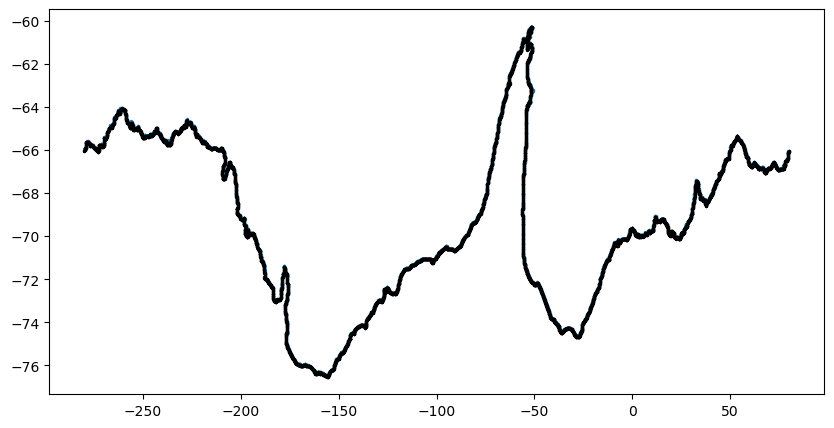

In [98]:
plt.figure(figsize=(10,5))
plt.scatter(lon_along_contour_a, lat_along_contour_a, s=2)
plt.scatter(lon_along_contour, lat_along_contour, s=2, color='k')

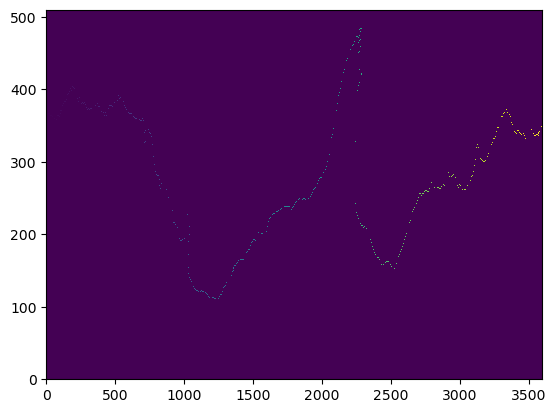

In [57]:
plt.pcolormesh(y_indices_masked_a)

(-71.5, -70.0)

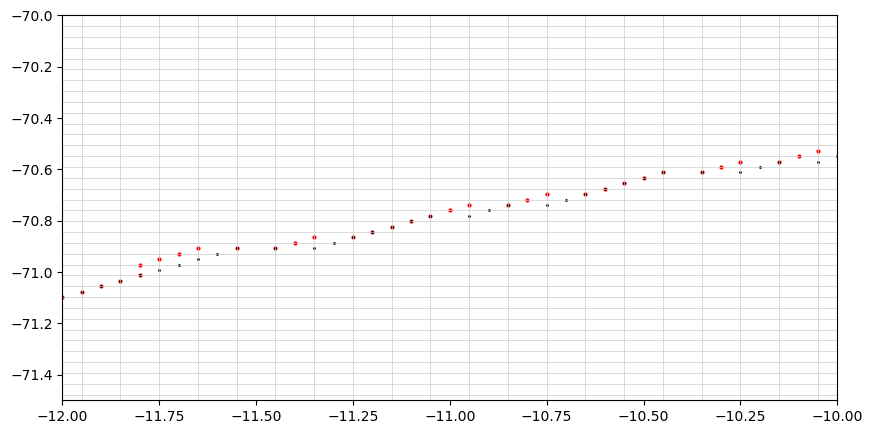

In [117]:
plt.figure(figsize=(10,5))
for ii in range(len(yt_ocean_a)):
    plt.axhline(yt_ocean_a[ii], color='0.8', linewidth=0.5)
for ii in range(len(xt_ocean_a)):
    plt.axvline(xt_ocean_a[ii], color='0.8', linewidth=0.5)
    
plt.scatter(lon_along_contour_a, lat_along_contour_a, s=4, c='r')
plt.scatter(lon_along_contour, lat_along_contour, s=1, color='k')

plt.xlim(-12,-10)
plt.ylim(-71.5,-70)

In [105]:
print(len(lat_along_contour_a))
print(len(lat_along_contour))

6002
5998


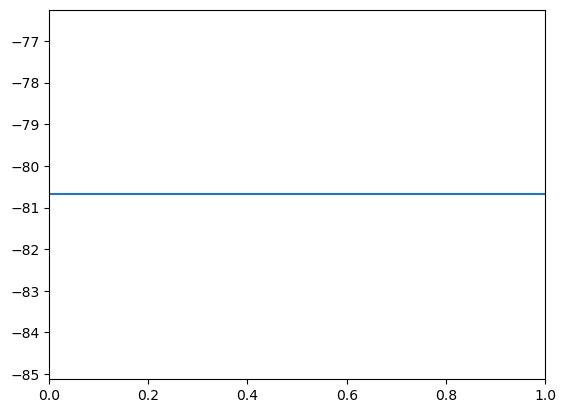

In [109]:
plt.axhline(yt_ocean_a[10])

Test load Adele's heat transport

In [81]:
data_adele = xr.open_dataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091/Antarctic_cross_slope/Ant_cross_slope_heat_terms_mean_1000m_2095-2095.nc')

In [128]:
data_adele

<xarray.Dataset>
Dimensions:                    (lon_bin_midpoints: 1428,
                                lat_bin_midpoints: 1428, lon_along_contour: 6002)
Coordinates:
  * lon_bin_midpoints          (lon_bin_midpoints) float64 -278.5 ... 78.25
  * lat_bin_midpoints          (lat_bin_midpoints) float64 -65.63 ... -66.49
  * lon_along_contour          (lon_along_contour) float64 -279.9 ... 80.0
Data variables:
    zonal_convergence          (lon_bin_midpoints) float64 ...
    cross_slope_heat_trans     (lon_bin_midpoints) float64 ...
    bin_width                  int64 ...
    bin_spacing                float64 ...
    heat_trans_across_contour  (lon_along_contour) float64 ...

In [100]:
print(data_adele.heat_trans_across_contour.mean().values)
print(data_adele.heat_trans_across_contour.std().values)
print(data_adele.heat_trans_across_contour.sum().values*1e-12)
print(len(data_adele.heat_trans_across_contour))

-711891171.0607568
656668886893.3892
-4.272770808706662
6002


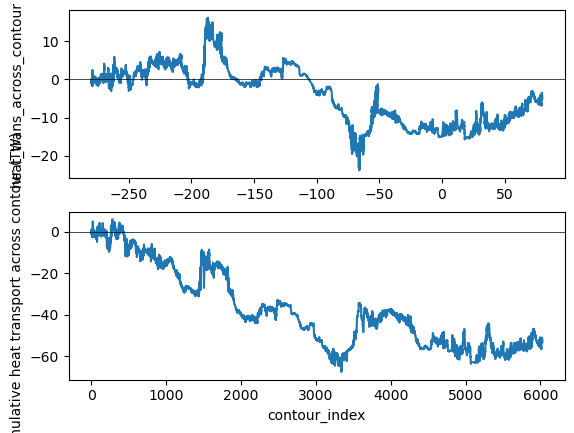

In [98]:
fig = plt.figure()

plt.subplot(211)
(data_adele.heat_trans_across_contour.cumsum()*1e-12).plot()
plt.xlabel('')
plt.axhline(0, color='k', linewidth=0.5)

plt.subplot(212)
(heat_trans_across_contour.cumsum('contour_index')*1e-12).plot()
plt.ylabel('Cumulative heat transport across contour (TW)')
plt.axhline(0, color='k', linewidth=0.5);

(-10.0, 10.0)

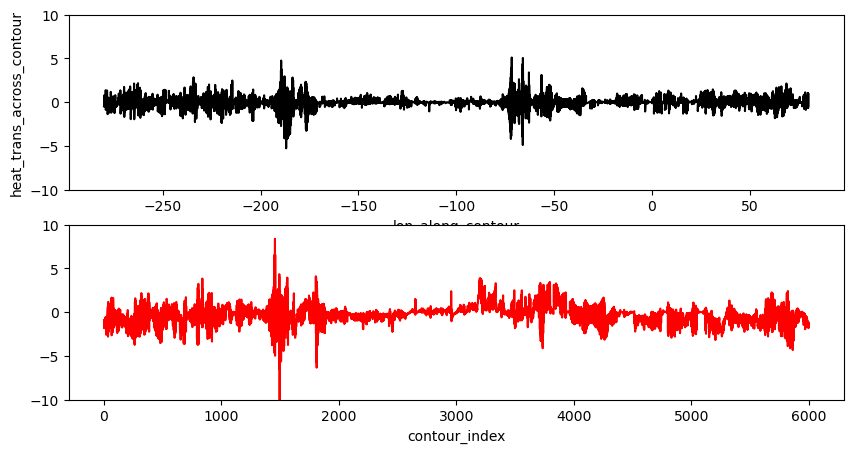

In [137]:
plt.figure(figsize=(10,5))

plt.subplot(211)
(data_adele.heat_trans_across_contour*1e-12).plot(color='k')
plt.ylim(-10, 10)
plt.subplot(212)
(heat_trans_across_contour*1e-12).plot(color='r')
plt.ylim(-10,10)

Text(0.5, 0, 'Longitude bins (used to calculate zonal convergence)')

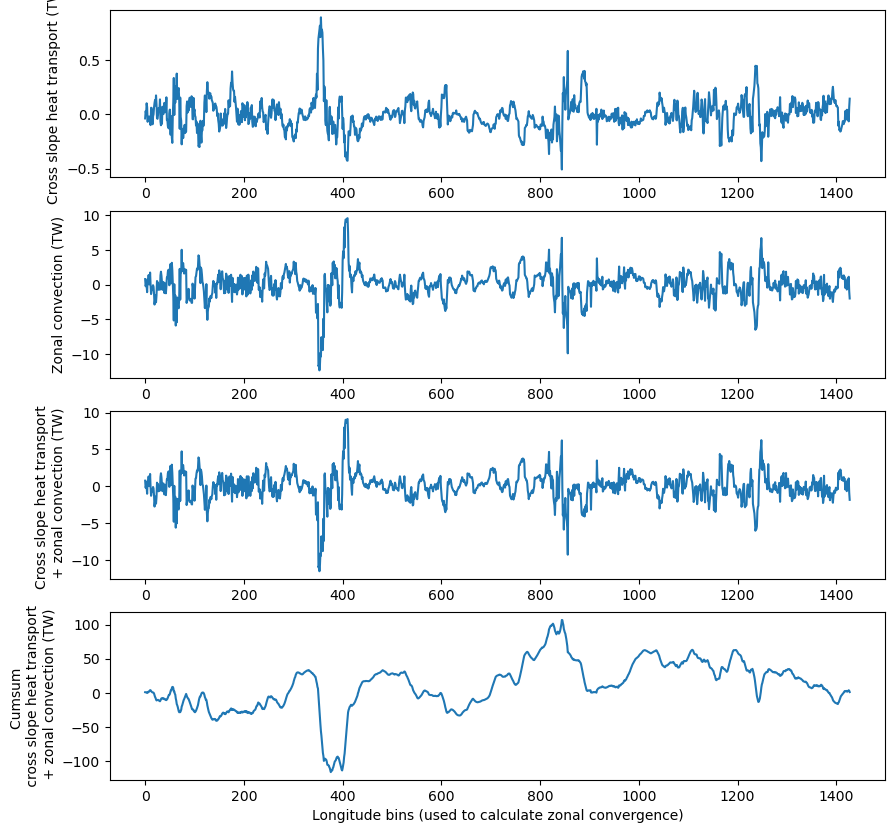

In [131]:
f = data_adele.heat_trans_across_contour.sum() / data_adele.cross_slope_heat_trans.sum()


fig = plt.figure(figsize=(10,10))

plt.subplot(411)
plt.plot(f*data_adele.cross_slope_heat_trans*1e-12)
plt.ylabel('Cross slope heat transport (TW)')

plt.subplot(412)
plt.plot(data_adele.zonal_convergence*1e-12)
plt.ylabel('Zonal convection (TW)')

plt.subplot(413)
plt.plot(((f*data_adele.cross_slope_heat_trans)+data_adele.zonal_convergence)*1e-12)
plt.ylabel('Cross slope heat transport \n + zonal convection (TW)')

plt.subplot(414)
plt.plot(np.cumsum(((f*data_adele.cross_slope_heat_trans)+data_adele.zonal_convergence))*1e-12)
plt.ylabel('Cumsum \n cross slope heat transport \n + zonal convection (TW)')
plt.xlabel('Longitude bins (used to calculate zonal convergence)')

---

## Open contour data, extract lat/lon on contour

In [11]:
data.files

['contour_mask_numbered',
 'contour_masked_above',
 'contour_depth',
 'xt_ocean',
 'yt_ocean',
 'mask_y_transport',
 'mask_x_transport',
 'mask_y_transport_numbered',
 'mask_x_transport_numbered']

In [12]:
mask_x_transport

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)

In [19]:
# convert isobath masks to data arrays, so we can multiply them later:
mask_x_transport = xr.DataArray(mask_x_transport, dims=["yt_ocean", "xu_ocean"], coords=[('yt_ocean', yt_ocean.values), ('xu_ocean', xu_ocean.values)])
mask_y_transport = xr.DataArray(mask_y_transport, dims=["yu_ocean", "xt_ocean"], coords=[('yu_ocean', yu_ocean.values), ('xt_ocean', xt_ocean.values)])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, dims=["yt_ocean", "xt_ocean"], coords=[('yt_ocean', yt_ocean.values), ('xt_ocean', xt_ocean.values)])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, dims=["yt_ocean", "xt_ocean"], coords=[('yt_ocean', yt_ocean.values), ('xt_ocean', xt_ocean.values)])

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

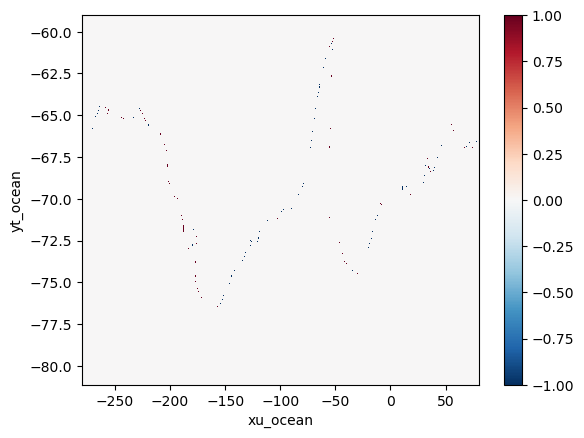

In [21]:
mask_x_transport.plot()

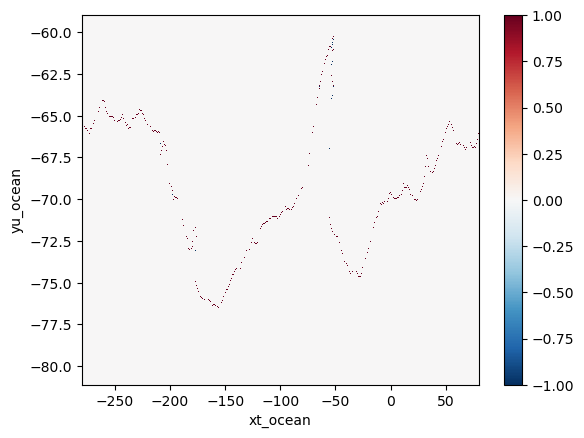

In [22]:
mask_y_transport.plot()

In [6]:
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))

# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])   
    lon_along_contour[count-1] = xu_ocean[ii].values
    lat_along_contour[count-1] = mask_x_transport_numbered.yt_ocean[jj].values
    
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
    count = int(count)
    jj = np.where(mask_y_transport_numbered==count)[0]
    ii = np.where(mask_y_transport_numbered==count)[1]
    lon_along_contour[count-1] = mask_x_transport_numbered.xt_ocean[ii].values
    lat_along_contour[count-1] = yu_ocean[jj].values

In [7]:
lat_along_contour

array([-66.00806249, -66.00806249, -66.00806249, ..., -66.05030184,
       -66.05030184, -66.02918216])

## Compute heat transports calculated online

In [74]:
# Note temp_yflux_adv is also positioned on north centre edge of t-cell.
# temp_yflux_adv = cp*rho*dzt*dxt*v*temp

temp_yflux = cc.querying.getvar(exp,'temp_yflux_adv',session,start_time=start_time, end_time=end_time)
temp_xflux = cc.querying.getvar(exp,'temp_xflux_adv',session,start_time=start_time, end_time=end_time)

# select latitude range:
temp_yflux = temp_yflux.sel(yu_ocean=lat_range).sel(time=slice(start_time,end_time))
temp_xflux = temp_xflux.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# time average and sum in depth:
temp_yflux = temp_yflux.mean('time').sum('st_ocean')
temp_xflux = temp_xflux.mean('time').sum('st_ocean')

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 693, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 540, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23453619058496 and this is thread id 23450154944256.
Exception closing connection <sqlite3.Connection object at 0x15540694d490>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/sqlalchemy/po

In [91]:
# save a long term average of vhrho_nt and uhrho_et:

outpath = '/g/data/v45/akm157/model_data/access-om2/'+exp+'/Antarctic_cross_slope/uhrho_vhrho_'+time_period+'.nc'
# check if already exists:
if os.path.exists(outpath):
    average_transports = xr.open_dataset(outpath)
    # extract arrays from dataset:
    uhrho_et = average_transports.uhrho_et
    vhrho_nt = average_transports.vhrho_nt
else:
    vhrho_nt = cc.querying.getvar(exp,'vhrho_nt',session,start_time=start_time, end_time=end_time)
    uhrho_et = cc.querying.getvar(exp,'uhrho_et',session,start_time=start_time, end_time=end_time)

    vhrho_nt = vhrho_nt.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
    uhrho_et = uhrho_et.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

    vhrho_nt = vhrho_nt.mean('time')
    uhrho_et = uhrho_et.mean('time')

    outpath = '/g/data/v45/akm157/model_data/access-om2/'+exp+'/Antarctic_cross_slope/uhrho_vhrho_'+time_period+'.nc'
    ds = xr.Dataset({'vhrho_nt': vhrho_nt,'uhrho_et':uhrho_et})
    ds.to_netcdf(outpath)
    ds.close()

In [75]:
# subtract freezing point heat transport:
yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','yt_ocean',session,n=1)
dxu = cc.querying.getvar('01deg_jra55v13_ryf9091','dxu',session,n=1)
dyt = cc.querying.getvar(exp,'dyt',session,n=1)
# give dxu and dyt correct coordinates:
dxu.coords['nj'] = yt_ocean.values
dxu.coords['ni'] = xt_ocean['xt_ocean'].values
dxu = dxu.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
dyt.coords['nj'] = yt_ocean.values
dyt.coords['ni'] = xt_ocean['xt_ocean'].values
dyt = dyt.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
# select latitude range:
dxu = dxu.sel(yt_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)

# Note that in newer mom5 versions this could also be done with ty_trans_int_z, 
# but there is a problem with this diagnostic in older runs, and even
# using ty_trans, there is a slight difference. Not sure why?

# Note vhrho_nt is v*dz*1035 and is positioned on north centre edge of t-cell.
# sum in depth:
vhrho_nt = vhrho_nt.sum('st_ocean')
uhrho_et = uhrho_et.sum('st_ocean')
# convert to transport:
vhrho_nt = vhrho_nt*dxu/rho_0
uhrho_et = uhrho_et*dyt/rho_0

# overwrite coords, so we can add the freezing point (with uhrho_et and vhrho_nt) without problems:
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
vhrho_nt.coords['yt_ocean'] = yu_ocean.values
vhrho_nt = vhrho_nt.rename(({'yt_ocean':'yu_ocean'}))
uhrho_et.coords['xt_ocean'] = xu_ocean.values
uhrho_et = uhrho_et.rename(({'xt_ocean':'xu_ocean'}))

freezing_point_heat_trans_zonal = cp*rho_0*uhrho_et*temp_freezing
freezing_point_heat_trans_meridional = cp*rho_0*vhrho_nt*temp_freezing

# compare both ways:
temp_yflux = temp_yflux - freezing_point_heat_trans_meridional
temp_xflux = temp_xflux - freezing_point_heat_trans_zonal

temp_yflux = temp_yflux.load()
temp_xflux = temp_xflux.load()

# multiply by isobath contour masks:
temp_yflux_with_mask = temp_yflux*mask_y_transport
temp_xflux_with_mask = temp_xflux*mask_x_transport

## Extract heat transport values along isobath contour:

In [76]:
# multiply by mask to get correct direction into or out of isobath contour:
heat_trans_across_contour = np.zeros((num_points))

# locations for zonal transport, already calculated indices above:
for count in x_indices:
    count = int(count)
    jj = int(np.where(mask_x_transport_numbered==count)[0])
    ii = int(np.where(mask_x_transport_numbered==count)[1])
    heat_trans_across_contour[count-1] += temp_xflux_with_mask[jj,ii].values
    
# locations for meridional transport, already calculated indices above:
for count in y_indices:
    count = int(count)
    jj = int(np.where(mask_y_transport_numbered==count)[0])
    ii = int(np.where(mask_y_transport_numbered==count)[1])
    heat_trans_across_contour[count-1] += temp_yflux_with_mask[jj,ii].values

## Convert cross-slope heat transport from isobath coordinate to longitude coordinate

In [78]:
# convert to longitude coordinate and average into 3 degree longitude bins:

# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)

# sum heat transport from isobath coord into new longitude coord:
cross_slope_heat_trans = np.zeros(n_bins)
for lon_bin in range(n_bins):
    heat_trans_this_bin = heat_trans_across_contour[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    cross_slope_heat_trans[lon_bin] = np.sum(heat_trans_this_bin)
    
# find average latitude of each bin, so we can plot back on the isobath:
lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

## Zonal heat convergence

In [79]:
# Need to make sure the zonal boundaries here match exactly with the zonal boundaries used for the 
# longitude averaging above, by using same bin_edge_indices.
# Just check if isobath point is on x or y grid. if x, sum up to this point from south.
# if on y grid, sum zonal transport on nearest u grid point to west.

zonal_heat_trans_west = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # west limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_west_index = int(bin_edge_indices_west[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_west_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_west_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_west_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_west_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_west_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # careful if ii=0, then we need heat trans from lon=80, because at limit of zonal grid
        if ii==0:
            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
        else:
            zonal_heat_trans_west[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

zonal_heat_trans_east = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # east limit:
    # reset these to False:
    on_x_grid = False
    on_y_grid = False
    # mask_x_transport_numbered etc indexing starts from 1 not 0, so add 1:
    isobath_east_index = int(bin_edge_indices_east[lon_bin]+1)
    # check if the point is on the x or y transport grid:
    if len(np.where(mask_x_transport_numbered==isobath_east_index)[0])>0:
        on_x_grid = True
        jj = int(np.where(mask_x_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_x_transport_numbered==isobath_east_index)[1])
    elif len(np.where(mask_y_transport_numbered==isobath_east_index)[0])>0:
        on_y_grid = True
        jj = int(np.where(mask_y_transport_numbered==isobath_east_index)[0])
        ii = int(np.where(mask_y_transport_numbered==isobath_east_index)[1])
    if on_x_grid == True:
        zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj,ii])
    # in this case we want transport half a grid point to the west:
    elif on_y_grid == True:
        # wrap around to east side of grid:
        if ii==0:
            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,-1])
        else:
            zonal_heat_trans_east[lon_bin] = np.sum(temp_xflux[:jj+1,ii-1])

zonal_convergence = zonal_heat_trans_east - zonal_heat_trans_west

## Save cross-slope and zonal convergence terms for this isobath

In [80]:
# convert to data arrays, so we can save as netcdf:
zonal_convergence = xr.DataArray(zonal_convergence, coords = [('lon_bin_midpoints', lon_bin_midpoints)])
cross_slope_heat_trans = xr.DataArray(cross_slope_heat_trans, coords = [('lon_bin_midpoints', lon_bin_midpoints)])
heat_trans_across_contour = xr.DataArray(heat_trans_across_contour,coords = [('lon_along_contour',lon_along_contour)])

In [6]:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+exp+'/Antarctic_cross_slope/Ant_cross_slope_heat_terms_online_'+str(isobath_depth)+'m_'+time_period+'.nc'
ds = xr.Dataset({'zonal_convergence': zonal_convergence,'cross_slope_heat_trans':cross_slope_heat_trans,
                'lon_bin_midpoints':lon_bin_midpoints,'lat_bin_midpoints':lat_bin_midpoints,
                 'bin_width':bin_width,'bin_spacing':bin_spacing,'heat_trans_across_contour':heat_trans_across_contour,
                'lon_along_contour':lon_along_contour})
ds.to_netcdf(outpath)

NameError: name 'zonal_convergence' is not defined